In [105]:
import talib
import datetime as dt
import pandas as pd

In [222]:
df=pd.read_csv('AXISBANK.csv')
df.head()

,date,open,high,low,close,volume
0,2015-02-02 09:15:00+05:30,585.95,592.85,584.60,592.40,218485
1,2015-02-02 09:30:00+05:30,592.60,595.30,591.95,594.85,190721
2,2015-02-02 09:45:00+05:30,595.00,595.40,593.35,594.05,125858
3,2015-02-02 10:00:00+05:30,594.05,594.65,593.00,593.60,73754
4,2015-02-02 10:15:00+05:30,593.40,595.00,592.00,594.20,129346


In [226]:
df["date"] = pd.to_datetime(df["date"])
df["ema_20"] = talib.EMA(df["close"], timeperiod=20)
df["ema_50"] = talib.EMA(df["close"], timeperiod=50)
df["ema_200"] = talib.EMA(df["close"], timeperiod=200)
df["slope_20"] = (df["close"] - df["close"].shift(20)) / 20
# Add Bollinger Bands
upper, middle, lower = talib.BBANDS(df["close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df["bb_upper"] = upper
df["bb_middle"] = middle
df["bb_lower"] = lower
df["bb_width"] = upper - lower
df["bb_percent"] = (df["close"] - lower) / (upper - lower)

# Add Volatility features
df["atr_14"] = talib.ATR(df["high"], df["low"], df["close"], timeperiod=14)
df["candle_body_size"] = abs(df["close"] - df["open"])
df["candle_range"] = df["high"] - df["low"]

# Add Regime label
def label_market(df, window=20, slope_thresh=0.01):
    labels = []
    for i in range(len(df)):
        if i < window:
            labels.append(None)
            continue
        sub = df.iloc[i-window:i]
        slope = (sub['close'].iloc[-1] - sub['close'].iloc[0]) / sub['close'].iloc[0]
        ema_20 = sub['close'].ewm(span=20).mean().iloc[-1]
        ema_50 = sub['close'].ewm(span=50).mean().iloc[-1]
        ema_200 = sub['close'].ewm(span=200).mean().iloc[-1]
        last_close = sub['close'].iloc[-1]
        if slope > slope_thresh and ema_20 > ema_50 and last_close > ema_200:
            labels.append("uptrend")
        elif slope < -slope_thresh and ema_20 < ema_50 and last_close < ema_200:
            labels.append("downtrend")
        else:
            labels.append("sideways")
    return labels

df["trend_regime"] = label_market(df)
# Add RSI
df["rsi_14"] = talib.RSI(df["close"], timeperiod=14)

# Binary: Price above EMA 200
df["price_above_ema200"] = (df["close"] > df["ema_200"]).astype(int)

# Time of Day label
def time_of_day_label(dt):
    hour, minute = dt.hour, dt.minute
    time_in_minutes = hour * 60 + minute
    if 555 <= time_in_minutes < 615:     # 9:15 to 10:15
        return "opening"
    elif 615 <= time_in_minutes < 780:   # 10:15 to 1:00
        return "midday"
    elif 780 <= time_in_minutes < 930:   # 1:00 to 3:30
        return "closing"
    else:
        return "off_market"


df["time_of_day"] = df['date'].map(time_of_day_label)

# Volatility regime (based on ATR percentile)
atr = df["atr_14"]
low_thresh = atr.quantile(0.33)
high_thresh = atr.quantile(0.66)

def vol_regime(a):
    if np.isnan(a): return None
    elif a < low_thresh: return "low"
    elif a > high_thresh: return "high"
    else: return "normal"

df["volatility_regime"] = atr.map(vol_regime)

# Inside Bar
df["inside_bar"] = ((df["high"] < df["high"].shift(1)) & (df["low"] > df["low"].shift(1))).astype(int)

# Bullish Engulfing (optional candlestick pattern)
df["bullish_engulfing"] = ((df["close"].shift(1) < df["open"].shift(1)) &  # previous candle red
                           (df["close"] > df["open"]) &                   # current candle green
                           (df["close"] > df["open"].shift(1)) & 
                           (df["open"] < df["close"].shift(1))).astype(int)

df.dropna(inplace=True)

In [227]:
df["time_of_day"].value_counts()

time_of_day
midday        18981
closing       17262
opening        6899
off_market       36
Name: count, dtype: int64

In [239]:
df.head()

,date,open,high,low,close,volume,ema_20,ema_50,ema_200,slope_20,...,atr_14,candle_body_size,candle_range,trend_regime,rsi_14,price_above_ema200,time_of_day,volatility_regime,inside_bar,bullish_engulfing
398,2015-02-24 15:00:00+05:30,550.40,553.90,550.20,553.75,425745,550.673869,553.104059,566.366750,0.3925,...,3.252399,3.35,3.70,sideways,56.945331,0,closing,high,0,0
399,2015-02-24 15:15:00+05:30,553.50,553.85,549.35,551.40,476231,550.743025,553.037233,566.217827,0.2450,...,3.341513,2.10,4.50,uptrend,50.885305,0,closing,high,0,0
400,2015-02-25 09:15:00+05:30,554.45,556.30,552.90,554.45,309308,551.096070,553.092635,566.100734,0.4175,...,3.452833,0.00,3.40,sideways,57.244791,0,opening,high,0,0
401,2015-02-25 09:30:00+05:30,554.45,555.75,553.50,554.70,177683,551.439301,553.155669,565.987294,0.4500,...,3.366917,0.25,2.25,uptrend,57.727949,0,opening,high,1,0
402,2015-02-25 09:45:00+05:30,554.50,555.00,553.25,553.90,113771,551.673654,553.184859,565.867023,0.4475,...,3.251423,0.60,1.75,uptrend,55.564091,0,opening,high,0,0


In [306]:

def label_bb_bounce_profit(df, price_col="close", lookahead=10):
    pos_ret=0
    neg_ret=0
    indices = []
    labels = []

    for i in range(1, len(df)):
        
        prev_close = df[price_col].iloc[i - 1]
        curr_close = df[price_col].iloc[i]
        bb_lower_prev = df['bb_lower'].iloc[i - 1]
        bb_lower_curr = df['bb_lower'].iloc[i]

        # Entry condition: price crossed above lower BB
        if prev_close < bb_lower_prev and curr_close >= bb_lower_curr:
            future_price = df[price_col].iloc[min(i + lookahead, len(df))-1]
            
            # tp =  1 * (df["atr_14"].iloc[i]/curr_close)
            # sl = -1* (df["atr_14"].iloc[i]/curr_close)
            # check_ts.append([tp,sl])
            entry_price = curr_close
            found_label = -1  # default: not profitable

            # for j in range(i + 1, min(i + lookahead, len(df))):
            #     future_price = df[price_col].iloc[j]
            #     ret = (future_price - entry_price) / entry_price

            #     if ret >= tp:
            #         found_label = 1
            #         break
            #     elif ret <= sl:
            #         found_label = 0
            #         break
            ret = (future_price - entry_price) 
            if ret >0:
                    pos_ret += ret
                    found_label = 1
            elif ret <=0 :
                    neg_ret += ret
                    found_label = 0

            indices.append(i)
            labels.append(found_label)

    label_df = df.iloc[indices].copy()
    label_df['label'] = labels
    return label_df,pos_ret,neg_ret


In [296]:
labeled_df = label_bb_bounce_profit(df,lookahead=7)
labeled_df['label'].value_counts()

label
0    738
1    641
Name: count, dtype: int64

In [257]:
#drop with label=-1
labeled_df.drop(labeled_df[labeled_df['label'] == -1].index, inplace=True)
labeled_df.reset_index(drop=True, inplace=True)
labeled_df['label'].value_counts()

label
0    751
1    628
Name: count, dtype: int64

In [272]:
labeled_df['trend_regime'].value_counts()

trend_regime
downtrend    928
sideways     451
Name: count, dtype: int64

In [316]:
labeled_df,p,n = label_bb_bounce_profit(df,lookahead=5)
print(labeled_df['label'].value_counts())
print("-"*50)
print(p,n)

label
0    744
1    635
Name: count, dtype: int64
--------------------------------------------------
2225.350000000001 -2567.199999999996


2443.5999999999967 -2763.050000000003


/var/folders/qd/gbhsmb7j2fq2sjvx6v7yhww80000gn/T/ipykernel_36079/718339039.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_corr.values, y=label_corr.index, palette="coolwarm")


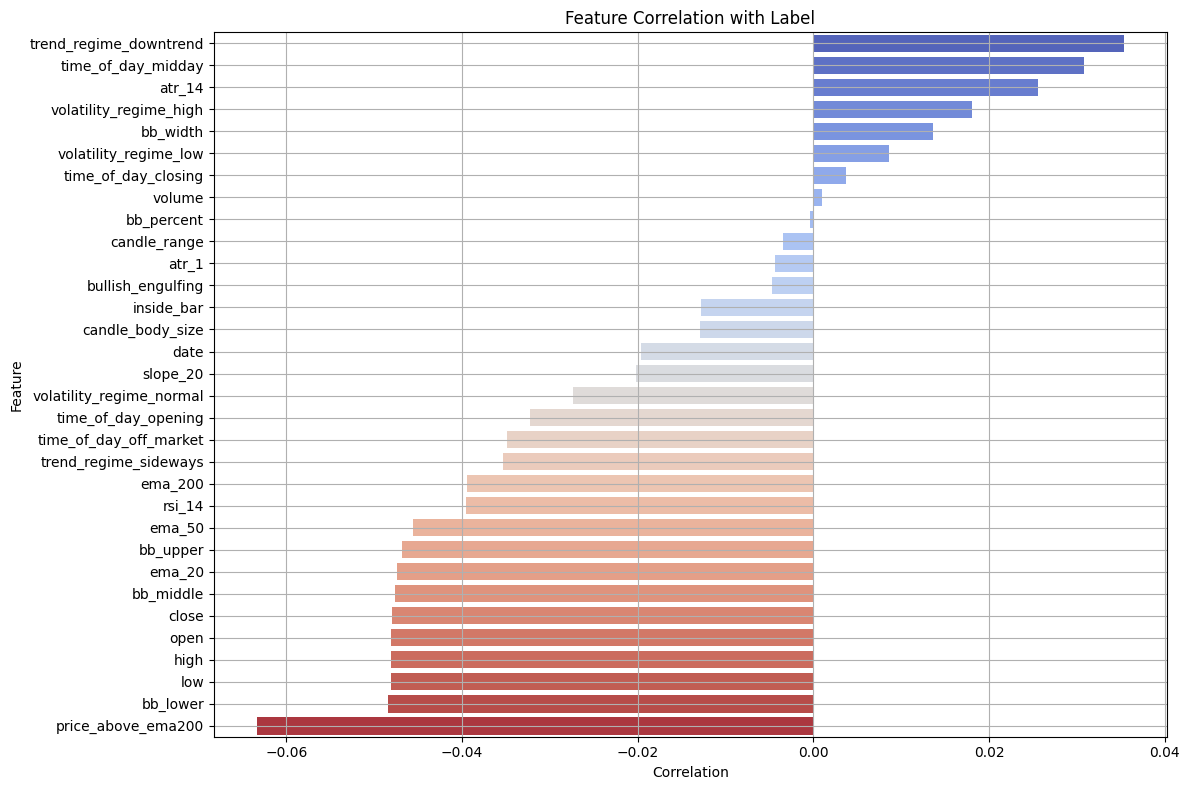

In [301]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# One-hot encode categorical variables
temp = pd.get_dummies(labeled_df)
temp['atr_1']=talib.ATR(temp["high"], temp["low"], temp["close"], timeperiod=1)

# Compute correlation matrix
corr_matrix = temp.corr()

# Get correlations with the label only
label_corr = corr_matrix["label"].drop("label").sort_values(ascending=False)

# Plot barplot
plt.figure(figsize=(12, 8))
sns.barplot(x=label_corr.values, y=label_corr.index, palette="coolwarm")
plt.title("Feature Correlation with Label")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [267]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [302]:
# Drop the label column first
feature_cols = [col for col in labeled_df.columns if col != "label"]

# Create dummies for object columns
df_encoded = pd.get_dummies(labeled_df[feature_cols], drop_first=True)
df_encoded.drop(columns=['date'],inplace=True)

X = df_encoded
y = labeled_df["label"]

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# === XGBoost Model ===
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# === RandomForest Model ===
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


/Users/virat/Documents/Trading/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:37:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [303]:
# === Evaluation Function ===
def evaluate(name, y_true, y_pred):
    print(f"==== {name} ====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n")

# === Evaluate both ===
evaluate("XGBoost", y_test, xgb_pred)
evaluate("Random Forest", y_test, rf_pred)

==== XGBoost ====
Accuracy: 0.5253623188405797
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.59       159
           1       0.44      0.42      0.43       117

    accuracy                           0.53       276
   macro avg       0.51      0.51      0.51       276
weighted avg       0.52      0.53      0.52       276

Confusion Matrix:
 [[96 63]
 [68 49]]


==== Random Forest ====
Accuracy: 0.5833333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66       159
           1       0.51      0.41      0.45       117

    accuracy                           0.58       276
   macro avg       0.57      0.56      0.56       276
weighted avg       0.57      0.58      0.57       276

Confusion Matrix:
 [[113  46]
 [ 69  48]]




In [148]:
check_ts[:10]

[[np.float64(585.9343581672996), np.float64(578.5437612218003)],
 [np.float64(576.3325169969602), np.float64(568.1116553353598)],
 [np.float64(570.6164221766414), np.float64(563.7557185489057)],
 [np.float64(566.445906229906), np.float64(559.2027291800628)],
 [np.float64(557.6211189306888), np.float64(550.0859207128742)],
 [np.float64(553.1401760406966), np.float64(544.9898826395356)],
 [np.float64(550.4346817643624), np.float64(542.2102121570917)],
 [np.float64(551.965118093804), np.float64(544.1899212707973)],
 [np.float64(637.1596109826086), np.float64(629.8102593449277)],
 [np.float64(621.6004729889529), np.float64(609.5996846740313)]]

In [ ]:
df['date'] = pd.to_datetime(df['date'])
# Set it as the index
df.set_index('date', inplace=True)
df=df.rename(columns={'date': 'DateTimeIndex','open':'Open','high':"High","low":"Low",'volume':'Volume','close':'Close'})
df.head()

,Open,High,Low,Close,Volume
date,,,,,
2015-02-02 09:15:00+05:30,585.95,592.85,584.60,592.40,218485
2015-02-02 09:30:00+05:30,592.60,595.30,591.95,594.85,190721
2015-02-02 09:45:00+05:30,595.00,595.40,593.35,594.05,125858
2015-02-02 10:00:00+05:30,594.05,594.65,593.00,593.60,73754
2015-02-02 10:15:00+05:30,593.40,595.00,592.00,594.20,129346


In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

In [ ]:
class BBSimpleWithStopLoss(Strategy):
    def init(self):
        price = self.data.Close
        self.bb = self.I(talib.BBANDS, price, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        self.bb_lower = self.bb[2]  # Lower band

    def next(self):
        price = self.data.Close[-1]
        if crossover(self.data.Close, self.bb_lower):
            stop_loss_price = price * 0.98  # 2% stop loss
            self.buy(sl=stop_loss_price)


In [103]:
backtest = Backtest(df, BBSimpleWithStopLoss, commission=0, exclusive_orders=True)
stats = backtest.run()

# 📊 Display results
print(stats)
backtest.plot()

/Users/virat/Documents/Trading/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '8h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


Start                     2015-02-02 09:15...
End                       2022-10-11 15:15...
Duration                   2808 days 06:00:00
Exposure Time [%]                    94.23536
Equity Final [$]                    12104.879
Equity Peak [$]                     14590.979
Return [%]                           21.04879
Buy & Hold Return [%]                27.37303
Return (Ann.) [%]                     2.78892
Volatility (Ann.) [%]                34.05392
CAGR [%]                              1.72894
Sharpe Ratio                           0.0819
Sortino Ratio                         0.13155
Calmar Ratio                          0.06265
Alpha [%]                            -0.00716
Beta                                  0.76922
Max. Drawdown [%]                   -44.51741
Avg. Drawdown [%]                    -2.85489
Max. Drawdown Duration     2059 days 18:00:00
Avg. Drawdown Duration       53 days 22:11:00
# Trades                                 1392
Win Rate [%]                      

/var/folders/qd/gbhsmb7j2fq2sjvx6v7yhww80000gn/T/ipykernel_36079/4011330349.py:6: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  backtest.plot()
/Users/virat/Documents/Trading/.venv/lib/python3.12/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p11256', ...)